In [1]:
from dask.distributed import Client

# Inicia un cliente de Dask con un clúster local y habilita el dashboard
client = Client()

# Imprime información sobre el cliente y el dashboard
print("Dashboard disponible en:", client.dashboard_link)

Dashboard disponible en: http://127.0.0.1:8787/status


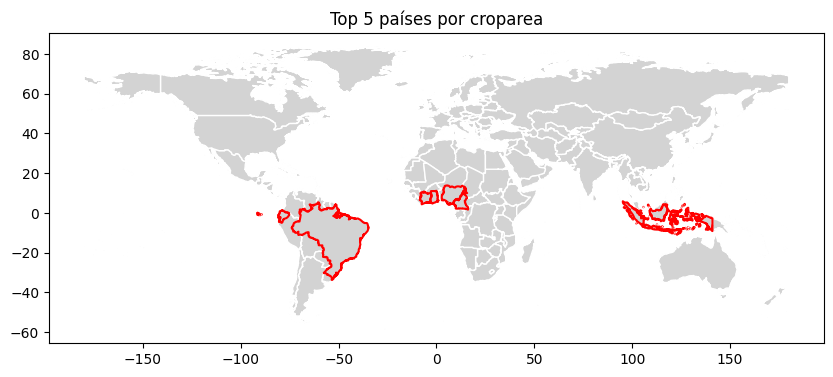

In [5]:

import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np

# 1. Leer el dataset de cacao
cocoa_ds = xr.open_dataset("/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_cocoa.nc")
cocoa = cocoa_ds["croparea"]

lat_vals = cocoa_ds["lat"].values
lon_vals = cocoa_ds["lon"].values

# Crear grilla 2D de lat, lon
lon2d, lat2d = np.meshgrid(lon_vals, lat_vals)
crop_vals = cocoa.values

# Aplanar la grilla para convertirla en columnas
lat_flat = lat2d.ravel()
lon_flat = lon2d.ravel()
crop_flat = crop_vals.ravel()

df = pd.DataFrame({
    "lat": lat_flat,
    "lon": lon_flat,
    "croparea": crop_flat
})

# 2. Filtrar celdas con croparea > 0
df = df[df["croparea"] > 0]

# 3. Convertir a GeoDataFrame de puntos
gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["lon"], df["lat"]),
    crs="EPSG:4326"
)

# 4. Leer el shapefile y asegurar CRS
provincias = gpd.read_file("/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/shapefile/world-administrative-boundaries.shp")
provincias = provincias.to_crs("EPSG:4326")

# 5. Hacer join espacial para asignar cada punto a su país/provincia
join_gdf = gpd.sjoin(provincias, gdf_points, how="inner", predicate="intersects")

# 6. Agrupar por la columna que identifica el país
#    Ajusta según tu shapefile (ej. "iso3", "COUNTRY", "NAME", etc.)
country_col = "iso3"  # <= cambia si necesitas otra columna
sum_crop = (
    join_gdf.groupby(country_col)["croparea"]
    .sum()
    .reset_index(name="sum_croparea")
)

# 7. Ordenar de mayor a menor y extraer los top 5
sum_crop = sum_crop.sort_values("sum_croparea", ascending=False)
top5_countries = sum_crop.head(7)[country_col].unique()

# 8. Filtrar el shapefile para quedarse solo con esos 5 países
provincias_top5 = provincias[provincias[country_col].isin(top5_countries)]

# (Opcional) plotear para verificar
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
provincias.plot(ax=ax, facecolor="lightgray", edgecolor="white")  # Todos los países (en gris)
provincias_top5.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1.5)  # Top 5 (en rojo)
ax.set_title("Top 5 países por croparea")
plt.show()

# provincias_top5 es tu shapefile reducido a los 5 países con mayor croparea

In [ ]:
import xarray as xr
import rasterio
from rasterio.transform import from_origin
import numpy as np
import leafmap

# Abrir NetCDF y extraer croparea
ds = xr.open_dataset("/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_cocoa.nc")
data = ds["croparea"].isel(time=0) if "time" in ds["croparea"].dims else ds["croparea"]

# Convertir a numpy y aplicar máscara
arr = data.values
arr_masked = np.where(arr > 0, arr, np.nan).astype("float32")

# Coordenadas
lat = data["lat"].values
lon = data["lon"].values


arr_masked = arr_masked[::-1]
lat = lat[::-1]

# Resolución y transform corregido
res_lat = abs(lat[1] - lat[0])
res_lon = abs(lon[1] - lon[0])
transform = from_origin(lon.min() - res_lon / 2, lat.max() + res_lat / 2, res_lon, res_lat)

# Guardar como GeoTIFF
tif_path = "/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/croparea_cocoa.tif"

with rasterio.open(
    tif_path, "w",
    driver="GTiff",
    height=arr_masked.shape[0],
    width=arr_masked.shape[1],
    count=1,
    dtype="float32",
    crs="EPSG:4326",
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(arr_masked, 1)

# Visualizar en Leafmap
m = leafmap.Map(center=[0, 0], zoom=2)
m.add_raster(tif_path, layer_name="Cocoa Area")
m.to_html("mapa_cocoa.html")

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]],
      shape=(3600, 7200))